In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/WELFake_Dataset.csv


# Using neural networks for NLP classification

This is a continuation from my previous work on the same dataset, titled [NLP Fake News classification: many methods](https://www.kaggle.com/code/ianpetrustan/nlp-fake-news-classification-many-methods/).

In the previous notebook, we focused on simpler vector representation methods, from BoW, to TFIDF, to average word vector via semantic vector representation from the GloVe pretrained model. 

In all cases, we used traditional machine learning methods to do the final classification, after the text was preprocessed and vectorised. 

Now, we will place a focus on neural networks instead, using embedding layers. We will also touch on sequential models, which allows for variable and sequential data to be read instead. 

## Cleaning and preprocessing

We run the same cleaning method as before, which involves lowercasing, removing stopwords, etc. 

In [5]:
## Reading the data

data = pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv', 
                  index_col=0)

## Cleaning 1: filling the missing data with spaces 
data = data.fillna(' ') ## aplying to na via fillna

## Cleaning 2: combine the text and the title
data['Full_text'] = data['title'] + data['text']


In [6]:
## Cleaning 3: lowercase, remove non alphanumeric, remove stopwords,
import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk
import time

## download the dictionary for stopwords
nltk.download('stopwords')

## get the set of stopwords 
stop_words_set = set(stopwords.words('english'))

## Load English tokenizer from spacy
nlp = English()
spacy_tokenizer = nlp.tokenizer ## make instance 

## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
def optimized_preprocess(texts): ## Takes in a list of texts, i.e. the entire corpus
    result = []
    
    # Tokenize using spaCy's tokenizer
    for text in texts:
        tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
        result.append(" ".join(tokens))
    
    return result


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
## Save the cleaned data as a new column 
s = time.time()
data['Full_text_cleaned'] = optimized_preprocess(data.Full_text)
time_to_clean = time.time() - s
print('Time to clean {:.2f}'.format(time_to_clean))

Time to clean 127.98


Check for empty texts in the data

In [8]:
## Subset the data for the empty full_text_cleaned 
empty_text = [len(text) == 0 for text in data.Full_text_cleaned]
print(data[empty_text])

                                                   title  \
795    https://fedup.wpengine.com/wp-content/uploads/...   
8909   https://fedup.wpengine.com/wp-content/uploads/...   
14238  https://fedup.wpengine.com/wp-content/uploads/...   
26286  https://fedup.wpengine.com/wp-content/uploads/...   
27236  https://fedup.wpengine.com/wp-content/uploads/...   
31816                                                      
42774  https://100percentfedup.com/served-roy-moore-v...   
44862  https://100percentfedup.com/12-yr-old-black-co...   
52702  https://100percentfedup.com/video-hillary-aske...   
68385  https://fedup.wpengine.com/wp-content/uploads/...   

                                                    text  label  \
795    https://fedup.wpengine.com/wp-content/uploads/...      1   
8909   https://fedup.wpengine.com/wp-content/uploads/...      1   
14238  https://fedup.wpengine.com/wp-content/uploads/...      1   
26286  https://fedup.wpengine.com/wp-content/uploads/...      1   
2723

In [9]:
data = data[~pd.Series(empty_text)]

# Converting text to sequences with Keras, with embedding layer in the neural network

How it works 

* integer encoding: the text_to_sequences method converts texts to integers based on the vocabulary of the corpus. 

* we then have a **sequence of integers** (text to sequences), since models cannot understand words but only numbers 

* we pad each vector such that there is a consistent number of integers 

* the first layer of the neural network will be the embedding layer, which is a special kind of layer that *looks up each integer (word index) and maps it to a dense vector*, which is the semantic representation, same as the one we used with GloVe. 

* then we connect to a fully connected layer, where the last layer will be a single neuron with a sigmoid activation function - since we are making a binary classification

### Before any tokenizing: train test split 

In [10]:
from sklearn.model_selection import train_test_split

## Following the same split from the previous exercise
X_train_texts, X_test_texts, y_train, y_test = train_test_split(data.Full_text_cleaned, data.label, test_size=0.2, random_state=42)

### Tokenizing 

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Instantiate the keras tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token = '<00v>') ## this is for out of vocab
## terms -- therefore when testing, if the model sees a word that has not been trained, 
## it will map it to 1 instead of removing the term 

print(tokenizer)

In [12]:
## Fit the tokenizer to the corpus 
s = time.time()
tokenizer.fit_on_texts(X_train_texts) ## use fit on texts method as we have a series or list of texts
time_to_tokenize = time.time() -s
print('Time taken to tokenize {:.2f}'.format(time_to_tokenize))
word_index = tokenizer.word_index

Time taken to tokenize 12.06


In [13]:
## Check the word_index 
print(type(word_index))

## See a few examples
print(type(word_index.items()))

## Save as a list and see some examples
list(word_index.items())[0:10]

<class 'dict'>
<class 'dict_items'>


[('<00v>', 1),
 ('said', 2),
 ('trump', 3),
 ('would', 4),
 ('president', 5),
 ('people', 6),
 ('one', 7),
 ('new', 8),
 ('clinton', 9),
 ('state', 10)]

For the key-value pairs in word_index, the keys are the vocabulary, and the values are the rank according to word frequency. 

Once again, the tokenising step examines the entire corpus and builds a dictionary. This will help us map words to integers later down the line.

In [14]:
print(len(word_index)) ## our vocab size is about 200k+

214351


### Turning to sequences, and then padding 

In [15]:
## we use the tokenizer that has already been fitted on a (training) corpus, to do the 
## sequencing based on that corpus
sequences = tokenizer.texts_to_sequences(data.Full_text_cleaned)

In [16]:
## check sequences 
print(type(sequences))

## check examples
print(sequences[0])
print("=========================\n")
print(sequences[1])

<class 'list'>
[54, 564, 187, 3976, 389, 1155, 2359, 2864, 1, 902, 385, 427, 400, 13, 161, 1, 1, 3419, 75, 1, 4813, 32, 6, 2359, 2984, 259, 935, 126, 141, 249, 591, 7340, 1232, 32, 6, 2359, 1105, 531, 1029, 113, 6, 61, 7, 4440, 75, 1, 935, 2896, 126, 3166, 420, 75, 1, 1002, 935, 126, 1, 146, 825, 563, 3075, 290, 243, 2163, 342, 5811, 7473, 32, 1, 146, 935, 243, 6100, 935, 126, 5571, 929, 1562, 17, 126, 1, 805, 243, 1, 1029, 32, 6, 2214, 3701, 935, 126, 777, 1008, 640, 420, 402, 4, 12, 2158, 1, 171, 559, 364, 1155, 627, 1, 488, 539, 6101, 113, 118, 2, 745, 443, 12, 19, 3432, 1, 7, 19, 2947, 2, 779, 171, 2947, 5225, 2648, 496, 813, 113, 745, 71, 32, 307, 1843, 3881, 237, 591, 7534, 1, 2359, 602, 1511, 6, 10, 1312, 9316, 7, 21, 178, 4, 766, 202, 3881, 1353, 70, 45, 443, 1, 171, 424, 301, 204, 1089, 1, 14, 777, 114, 1, 530, 530, 2, 112, 591, 7534, 1188, 424, 633, 2217, 512, 218, 5222, 456, 2, 1835, 1210, 12, 48, 1835, 355, 522, 70, 642, 283, 2648, 2, 158, 62, 1, 591, 7534, 2, 51, 443, 1, 1

We have a list of list, and the lengths are unequal due to sentences of differing lengths

In [17]:
## See the lengths of first 10 documents 
[len(text) for text in sequences[0:10]]

## Get entire list of lengths
lengths_of_texts =  [len(text) for text in sequences]

## Range of values
print("Max length is {}".format(np.max(lengths_of_texts)))
print("Min length is {}".format(np.min(lengths_of_texts)))
print("Mean and median are {:.2f}, {}".format(np.mean(lengths_of_texts), np.median(lengths_of_texts)))

Max length is 20429
Min length is 1
Mean and median are 307.19, 232.0


Visualise the distribution of lengths. This is also why we have to perform padding, so that we can fit a consistent set of inputs into the neural network

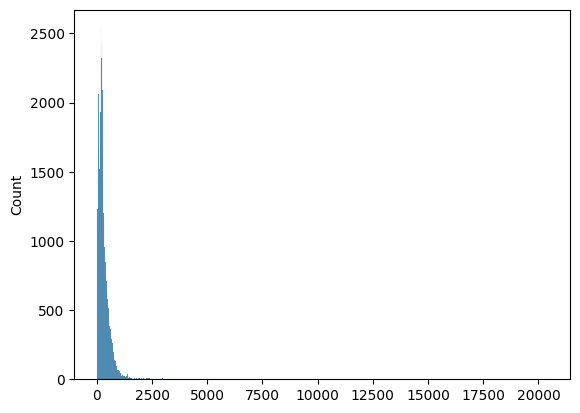

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(lengths_of_texts)
plt.show()

We can see that the distribution of lengths of the texts differ greatly but is also very very right skewed, i.e. most of the text lengths exist somewhere between 0 and 1000, but a few stretch up till 20k in length. 

In [19]:
## Distribution of lengths -- anomalies
data['text_length'] = data.Full_text_cleaned.str.len()
anomalies = data.text_length > 2500
print('Number of texts with more than 2500:  {}'.format(sum(anomalies)))
percent_anom = sum(anomalies)/len(data)
print('Percentage of texts with more than 2500:  {:.2f}'.format(percent_anom))

## anomalies
data[anomalies][['Full_text_cleaned', 'text_length', 'label']]

## distribution of lengths across labels
data[anomalies].value_counts('label')

Number of texts with more than 2500:  21458
Percentage of texts with more than 2500:  0.30


label
0    13141
1     8317
Name: count, dtype: int64

In [20]:
## Get sequences for train and test input data
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

#### Value for maxlen -- choose average length of all text 

Instead of using the default, which ie 'None' and would result in padding up to the max length of our train set -- which can up to 20k -- would give us too large a dimension. Instead we use the average length first, which is about 300. 

In [21]:
## Padding 
from tensorflow.keras.preprocessing.sequence import pad_sequences

## For length to pad till, we use the average length of all texts 
avg_length_text = int(np.mean(lengths_of_texts))

X_train_pad = pad_sequences(X_train_seq, maxlen=avg_length_text, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=avg_length_text, padding='post', truncating='post')

In [22]:
## Check results of padding 
print(X_train_pad.shape)
print(X_test_pad.shape)

(57699, 307)
(14425, 307)


In [23]:
## See some examples 
print(X_train_pad[0:5]) ## we can see the padding effect for the 2nd, 3rd, 5th examples

[[  18  115    1 ...  330   31   34]
 [2586 2719 8814 ...    1    1    1]
 [  27    9  913 ...    0    0    0]
 [5047  570    1 ...    0    0    0]
 [ 799 1393    1 ...  755 7983  758]]


# Model 1 : Simple neural network with embedding layer 

For our first model, we will use:

Architecture: Basic fully connected neural network
* Embedding layer at the start
* 1 Hidden layer (16 neurons)
* Batch normalisation -- helps with convergence (stabilises training by making sure the intermediate layer activations are non-shifting, i.e. internal covariate shift)

Others 
* Early stopping (patience = 10) -- reduces overfitting 
* Mini batch training (below)
* Adam optimiser: adaptive learning rate optimiser that adjusts the LR based on historical gradients -- i.e. if the gradients have been large, then the LR will be large as well to take advantage of 'steeper slopes' 

In [24]:
print(X_train_pad.shape)
y_train.shape

(57699, 307)


(57699,)

Recall that we have 57k training instances, hence one full epoch might take a while to complete. We can add mini-batch gradient descent to speed up the training time.

In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [26]:
from keras.models import Sequential # for the model 
from keras.layers import Embedding, Flatten, Dense, BatchNormalization ## for the layers
from keras.callbacks import EarlyStopping # for tailoring early stopping, to reduce overfitting 

# Define the model
model = Sequential([
    Embedding(input_dim=len(word_index), # input dimension = size of vocab
              output_dim=16, # allow the embedded space to have 16 dimensions
              input_length=avg_length_text), # input length = length of sequences
    Flatten(), # this will flatten to a layer with 307 x 16 neurons
    Dense(16, activation='relu'),
    BatchNormalization(), # Add batch normalization here
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping with a patience of 10 epochs (you can adjust this as needed)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model -- save history so that we can plot fitting history, such as loss and accuracy 
history = model.fit(X_train_pad, y_train, epochs=100, # increased epochs as early stopping will determine when to stop
                    batch_size = 200, # for faster training 
                    validation_data=(X_test_pad, y_test),
                    callbacks=[early_stop]) # Add the early stopping callback here


Epoch 1/100
289/289 [==============================] - 50s 148ms/step - loss: 0.2524 - accuracy: 0.8858 - val_loss: 0.2029 - val_accuracy: 0.9573
Epoch 2/100
289/289 [==============================] - 22s 77ms/step - loss: 0.0486 - accuracy: 0.9849 - val_loss: 0.1157 - val_accuracy: 0.9573
Epoch 3/100
289/289 [==============================] - 13s 46ms/step - loss: 0.0101 - accuracy: 0.9982 - val_loss: 0.1271 - val_accuracy: 0.9593
Epoch 4/100
289/289 [==============================] - 10s 34ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 0.1456 - val_accuracy: 0.9597
Epoch 5/100
289/289 [==============================] - 8s 27ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.1469 - val_accuracy: 0.9606
Epoch 6/100
289/289 [==============================] - 7s 22ms/step - loss: 5.0256e-04 - accuracy: 1.0000 - val_loss: 0.1561 - val_accuracy: 0.9592
Epoch 7/100
289/289 [==============================] - 4s 15ms/step - loss: 2.8615e-04 - accuracy: 1.0000 - val_loss: 0.1569 - 

In [27]:
## History for the important information that was saved during fitting 
print(type(history.history))
print((history.history.keys())) ## these are the information that we can visualise 

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Visualise fitting process 

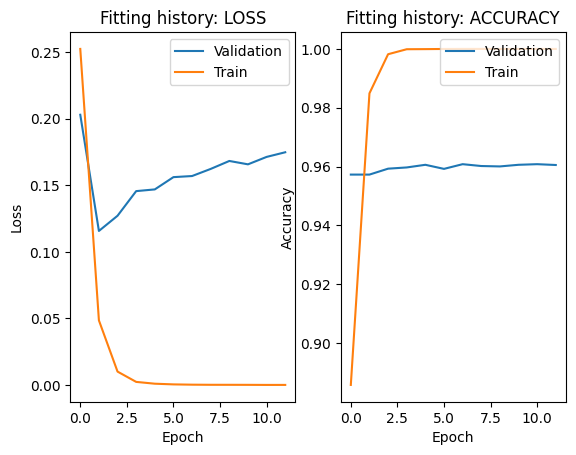

In [28]:
plt.subplot(1,2,1)
plt.plot(history.history['val_loss']) ## validation loss 
plt.plot(history.history['loss']) ## training loss (should be decreasing)
plt.title("Fitting history: LOSS")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy']) ## validation loss 
plt.plot(history.history['accuracy']) ## training loss (should be decreasing)
plt.title("Fitting history: ACCURACY")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')


plt.show()

## Evaluate Model 1

In [29]:
## Test set 
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

451/451 [==============================] - 1s 2ms/step - loss: 0.1748 - accuracy: 0.9606
Test Loss: 0.1747799962759018
Test Accuracy: 0.9605545997619629


In [30]:
## Train set 
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)

Final Training Loss: 0.00010965725232381374
Final Training Accuracy: 0.9999826550483704
Final Validation Loss: 0.1747799664735794
Final Validation Accuracy: 0.9605545997619629


We can see that the evaluation on the test set is the same as the evaluation on the validation set from the fitting process, since we added our test set as the validation data during the training. 

## Outcome

We can see that our training accuracy is really high, compared to our validation accuracy. This could be the presence of overfitting. We can take steps to reduce this in the next model

## Model 1.1

Some changes to the model that we can test out

* REDUCE EMBEDDING VECTOR DIMENSION -- from 16 to 10 
* Adding a dropout layer

In [31]:
from keras.layers import Dropout


model_2 = Sequential([
    Embedding(input_dim=len(word_index), output_dim=10, input_length=avg_length_text),
    Flatten(),
    Dense(10, activation='relu'),  # Matched with embedding output dim
    Dropout(0.5),  # Adding dropout
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_2 = model.fit(X_train_pad, y_train, epochs=50, batch_size=200, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/50
289/289 [==============================] - 3s 11ms/step - loss: 6.6694e-05 - accuracy: 1.0000 - val_loss: 0.1791 - val_accuracy: 0.9606
Epoch 2/50
289/289 [==============================] - 4s 14ms/step - loss: 5.4616e-05 - accuracy: 1.0000 - val_loss: 0.1813 - val_accuracy: 0.9605
Epoch 3/50
289/289 [==============================] - 3s 11ms/step - loss: 5.1805e-05 - accuracy: 1.0000 - val_loss: 0.1873 - val_accuracy: 0.9609
Epoch 4/50
289/289 [==============================] - 3s 10ms/step - loss: 7.0489e-05 - accuracy: 1.0000 - val_loss: 0.1893 - val_accuracy: 0.9608
Epoch 5/50
289/289 [==============================] - 5s 16ms/step - loss: 1.7610e-04 - accuracy: 1.0000 - val_loss: 0.1984 - val_accuracy: 0.9591
Epoch 6/50
289/289 [==============================] - 3s 10ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.4254 - val_accuracy: 0.9392
Epoch 7/50
289/289 [==============================] - 4s 13ms/step - loss: 0.0479 - accuracy: 0.9824 - val_loss: 0.1408 - 

## Evaluate model 2 

In [32]:
final_train_loss_2 = history_2.history['loss'][-1]
final_train_accuracy_2 = history_2.history['accuracy'][-1]

final_val_loss_2 = history_2.history['val_loss'][-1]
final_val_accuracy_2 = history_2.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_2)
print("Final Training Accuracy:", final_train_accuracy_2)
print("Final Validation Loss:", final_val_loss_2)
print("Final Validation Accuracy:", final_val_accuracy_2)

Final Training Loss: 6.162696809042245e-05
Final Training Accuracy: 0.9999826550483704
Final Validation Loss: 0.21260832250118256
Final Validation Accuracy: 0.9581975936889648


The validation accuracy has not changed much, whereas the training accuracy is still really high. We can try one last round of increasing regularisation

## Model 1.3

* Reduce embedding dimension further (to 8)
* Add some L2 regularisation (regularisation penalty hyperparameter set to 0.01)

In [33]:
from keras.layers import Dropout
from keras.regularizers import l2

model_3 = Sequential([
    Embedding(input_dim=len(word_index), output_dim=8, input_length=avg_length_text),
    Flatten(),
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Adding dropout
    Dense(1, activation='sigmoid')
])

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Decrease patience, allow restore to best weights during patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_3 = model_3.fit(X_train_pad, y_train, epochs=50, batch_size=200, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])


Epoch 1/50
289/289 [==============================] - 46s 154ms/step - loss: 0.5147 - accuracy: 0.7893 - val_loss: 0.2914 - val_accuracy: 0.9313
Epoch 2/50
289/289 [==============================] - 22s 78ms/step - loss: 0.3048 - accuracy: 0.9155 - val_loss: 0.2207 - val_accuracy: 0.9424
Epoch 3/50
289/289 [==============================] - 12s 42ms/step - loss: 0.2489 - accuracy: 0.9345 - val_loss: 0.1894 - val_accuracy: 0.9517
Epoch 4/50
289/289 [==============================] - 8s 29ms/step - loss: 0.2181 - accuracy: 0.9442 - val_loss: 0.1685 - val_accuracy: 0.9572
Epoch 5/50
289/289 [==============================] - 6s 20ms/step - loss: 0.1971 - accuracy: 0.9514 - val_loss: 0.1574 - val_accuracy: 0.9566
Epoch 6/50
289/289 [==============================] - 5s 19ms/step - loss: 0.1783 - accuracy: 0.9575 - val_loss: 0.1470 - val_accuracy: 0.9626
Epoch 7/50
289/289 [==============================] - 5s 19ms/step - loss: 0.1650 - accuracy: 0.9617 - val_loss: 0.1441 - val_accuracy: 0.

## Evaluate Model 1.3

In [34]:
final_train_loss_3 = history_3.history['loss'][-1]
final_train_accuracy_3 = history_3.history['accuracy'][-1]

final_val_loss_3 = history_3.history['val_loss'][-1]
final_val_accuracy_3 = history_3.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_3)
print("Final Training Accuracy:", final_train_accuracy_3)
print("Final Validation Loss:", final_val_loss_3)
print("Final Validation Accuracy:", final_val_accuracy_3)

Final Training Loss: 0.09710448235273361
Final Training Accuracy: 0.9779025912284851
Final Validation Loss: 0.14357826113700867
Final Validation Accuracy: 0.9660311937332153


### Training accuracy has finally decreased, while validation accuracy has increased. Validation loss has also decrease from the last iteration

## Compare all basic neural networks so far

In [35]:
models_comparison = pd.DataFrame({'Model': ['NN1', 'NN2', 'NN3'],
                                 'Train_loss' :[final_train_loss,final_train_loss_2,final_train_loss_3 ],
                                 'Train_acc' : [final_train_accuracy,final_train_accuracy_2,final_train_accuracy_3 ],
                                 'Val_loss' : [final_val_loss,final_val_loss_2,final_val_loss_3 ],
                                  'Val_acc' : [final_val_accuracy,final_val_accuracy_2,final_val_accuracy_3 ]
                                 })

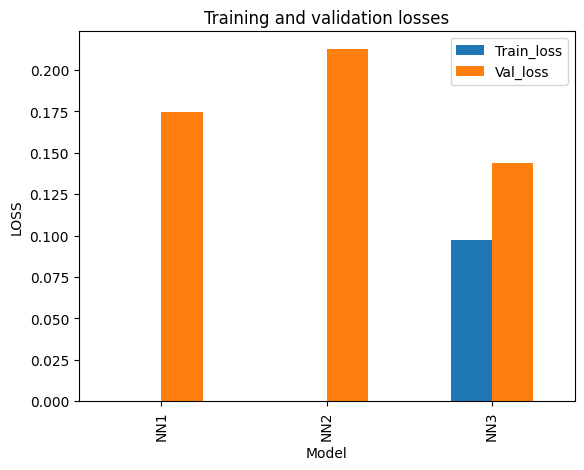

In [36]:
models_comparison[['Model', 'Train_loss', 'Val_loss']].plot(kind = 'bar', x = 'Model')
plt.ylabel("LOSS")
plt.title("Training and validation losses")
plt.show()

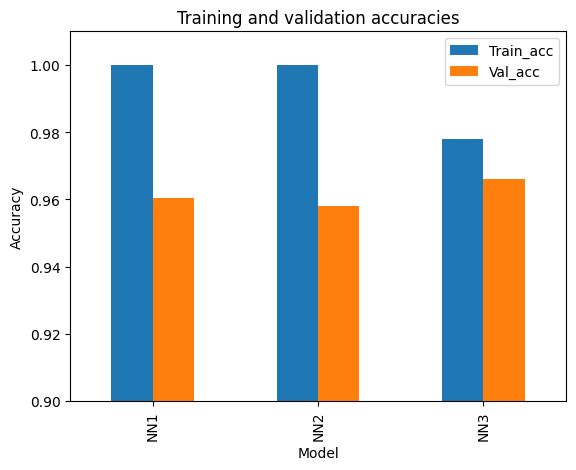

In [37]:
models_comparison[['Model', 'Train_acc', 'Val_acc']].plot(kind = 'bar', x = 'Model')
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies")
plt.ylim((0.9,1.01))
plt.show()

# Testing from external sources: 

Fake news from theonion.com: source: https://www.theonion.com/man-feels-like-bystanders-are-arguing-for-him-to-put-gu-1850904549

Real news from BBC: source: https://www.bbc.co.uk/news/business-67056069

I will take a snippet from both via copy and paste

In [38]:
bbc_snippet = """The UK faces another five years of high interest rates to stem rising prices, an influential global group has warned.
The International Monetary Fund expects the UK to have the highest inflation and slowest growth next year of any G7 economy including the US, France, Germany, Canada, Italy and Japan.
However, the Treasury said recent revisions to UK growth had not been factored in to the IMF's report.
The outlook was drawn up before this weekend's developments in Israel.
Forecasts are never perfect given the many factors that affect economic growth - from geopolitics to the weather. But such reports can point in the right direction, especially where they align with other forecasts.
The IMF, an international organisation with 190 member countries, has said the forecasts it makes for growth the following year in most advanced economies have, more often than not, been within about 1.5 percentage points of what actually happens.
In July last year, it forecast that the UK economy would grow by 3.2% in 2022. It revised that upwards to 4.1% at the start of this year.
But official UK figures released last month estimated that the country's economy actually expanded by 4.3% in 2022.
According to the IMF's latest forecast which it produces every six months, it expects the UK to grow more quickly than Germany in 2023, keeping the UK out of bottom place for growth among the G7.
But it downgraded the UK's prospects for growth next year, estimating the economy will grow by 0.6%, making it the slowest growing developed country in 2024 - widely predicted to be a general election year."""

In [39]:
theonion_snippet = """Claiming they had already made up their minds, area man Karl Wooley told reporters Tuesday that he felt like the bystanders who were urging him to put his gun down were arguing in bad faith. “If I’m being honest, it sort of feels like these onlookers are only thinking of themselves when they tell me to drop my pistol,” said Wooley, who observed that no one had even asked him to explain his reasoning for shouting at the top of his lungs and waving around a semiautomatic firearm. “Truth be told, they poisoned the well the second they tried to tackle me and forcibly rip the gun from my hands. But the worst part is how condescending they are—saying things like, ‘Hey, buddy, you don’t really want to do this.’ Maybe if they’d bothered to find out where I’m coming from and what my thoughts on the matter are, they’d know this is exactly what I want to be doing.” At press time, Wooley was reportedly shaking his head at how disrespectful his victims had become when they began resorting to ad hominem attacks like “You’re a monster” as he shot them to death."""

In [40]:
print("Length of BBC snippet",len(bbc_snippet.split()))
print("Length of theonion snippet", len(theonion_snippet.split()))

Length of BBC snippet 269
Length of theonion snippet 194


## Preprocessing: cleaning

In [41]:
## Run the cleaning function from before
## Recall that the function takes in a list of text
bbc_cleaned = optimized_preprocess([bbc_snippet])
theonion_cleaned = optimized_preprocess([theonion_snippet])

In [42]:
## Check 
print(bbc_cleaned)
print('\n \n ======================================================== \n \n')
print(theonion_cleaned)

print('\n \n ======================================================== \n \n')

print('BBC length after cleaning: ',len(bbc_cleaned[0].split()))
print('\n \n ======================================================== \n \n')
print('theonion length after cleaning: ',len(theonion_cleaned[0].split()))

['uk faces another five years high interest rates stem rising prices influential global group warned international monetary fund expects uk highest inflation slowest growth next year economy including us france germany canada italy japan however treasury said recent revisions uk growth factored imf report outlook drawn weekend developments israel forecasts never perfect given many factors affect economic growth geopolitics weather reports point right direction especially align forecasts imf international organisation member countries said forecasts makes growth following year advanced economies often within percentage points actually happens july last year forecast uk economy would grow revised upwards start year official uk figures released last month estimated country economy actually expanded according imf latest forecast produces every six months expects uk grow quickly germany keeping uk bottom place growth among downgraded uk prospects growth next year estimating economy grow mak

## Preprocessing: sequencing and padding

#### Sequencing 

In [43]:
bbc_seq = tokenizer.texts_to_sequences(bbc_cleaned)
theonion_seq = tokenizer.texts_to_sequences(theonion_cleaned)

## Check
print(bbc_seq[0]);print(len(bbc_seq[0]))
print(theonion_seq)

[1475, 1617, 88, 338, 34, 187, 557, 1307, 5963, 1774, 1667, 3090, 366, 82, 1025, 220, 3753, 879, 4005, 1475, 1448, 3371, 1, 979, 117, 20, 423, 77, 19, 856, 693, 1398, 2023, 1076, 191, 1758, 2, 197, 1, 1475, 979, 1, 8458, 147, 5832, 2582, 1042, 4612, 374, 9100, 107, 1914, 296, 28, 3420, 2439, 250, 979, 1, 2902, 334, 195, 53, 1946, 543, 8798, 9100, 8458, 220, 7164, 356, 192, 2, 9100, 485, 979, 389, 20, 2747, 4833, 359, 378, 2057, 674, 276, 1407, 459, 31, 20, 5688, 1475, 423, 4, 2083, 5598, 1, 443, 20, 183, 1475, 1775, 383, 31, 190, 1805, 38, 423, 276, 3088, 64, 8458, 544, 5688, 7669, 123, 496, 225, 4005, 1475, 2083, 819, 693, 1559, 1475, 2232, 181, 979, 165, 1, 1475, 4205, 979, 117, 20, 1, 423, 2083, 246, 1, 903, 2362, 38, 1751, 3014, 127, 30, 20]
147
[[1625, 171, 46, 3035, 523, 118, 6886, 1, 36, 428, 141, 1004, 12, 1, 3075, 152, 398, 2846, 468, 1528, 2473, 1276, 2420, 12, 1, 1205, 465, 1749, 8720, 2, 1, 4449, 7, 22, 131, 1443, 7335, 5011, 170, 1, 7065, 110, 1, 5367, 612, 36, 8177, 62, 2

#### Padding

In [44]:
bbc_pad = pad_sequences(bbc_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')
theonion_pad = pad_sequences(theonion_seq, maxlen=  avg_length_text, padding = 'post', truncating = 'post')

In [46]:
## Check
print(bbc_pad.shape)
print(bbc_pad[0].shape)
print(len(bbc_pad[0]))  ## the first in the list is the padded sequence 


(1, 307)
(307,)
307


## Testing the models on real (BBC) and fake (The Onion)

In [47]:
print(bbc_pad.shape)
print(model.summary())

(1, 307)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 307, 16)           3429616   
                                                                 
 flatten (Flatten)           (None, 4912)              0         
                                                                 
 dense (Dense)               (None, 16)                78608     
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,508,305
Trainable params: 3,508,273
Non-trainable params: 32
____________________________________

In [48]:
print(model.predict(bbc_pad))
print(model.predict(theonion_pad))

print('\n\n ======================= \n\n')

print(model_2.predict(bbc_pad))
print(model_2.predict(theonion_pad))

print('\n\n ======================= \n\n')

print(model_3.predict(bbc_pad))
print(model_3.predict(theonion_pad))

print('\n\n ======================= \n\n')



1/1 [==============================] - 0s 94ms/step
[[0.00856291]]
1/1 [==============================] - 0s 19ms/step
[[0.95998454]]




1/1 [==============================] - 0s 52ms/step
[[0.50542796]]
1/1 [==============================] - 0s 20ms/step
[[0.50525165]]




1/1 [==============================] - 0s 54ms/step
[[0.78573525]]
1/1 [==============================] - 0s 20ms/step
[[0.19193128]]






## Results: MODEL 3 CLEARLY WINS 

In this case, model 1 and 2 fail to convincingly separate out both test observations, despite one clearly being a false article. Specifically, model 1 predicted both to be true articles (with the output of the model being very close to 0), while model 2 was on the fence, predicting both to be around the 50% threshold, not being able to confidently choose either side. 

This is where model 3 clearly excelled, having predicted 0.1 probability that the BBC article was false, and 0.87 for The Onion, displaying a large confidence in the correct answers. 

In [49]:
## recap on the models 

print(model.summary())
print("\n\n=================================================================================================== \n\n")
print(model_2.summary())
print("\n\n=================================================================================================== \n\n")
print(model_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 307, 16)           3429616   
                                                                 
 flatten (Flatten)           (None, 4912)              0         
                                                                 
 dense (Dense)               (None, 16)                78608     
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,508,305
Trainable params: 3,508,273
Non-trainable params: 32
_____________________________________________

# Moving onto sequential models (RNNs, LSTMs)

So far, we have been dealing with models that treat predictors (words) independently and have not been able to incorporate any sequentiality which is obviously critical in speech and text. Words in a sentence have a particular order that otherwise would not make sense to another human being. So far, we have been using models that could hopefully detect words that are commonly used in real vs fake articles, instead of properly understanding the text which could lead to better results. 

* Furthermore, sequantial models can allow for articles of varying length. RNNs and LSTMs handle them more naturally. 

In this case, we are doing a special form of prediction that is **'many to one'**, where we take a sequence of words but only produce a single output, but where the decision is only made at the last word. 

## Model 2.1: basic RNN 

We will use a basic recurrent layer. There are some limitations, such as exploding/vanishing gradients due to the 'recurrent' nature and may struggle with long term dependencies, as our documents have varying lengths and a large proportion of them are high in lengths. 

As StatQuest explains, they are thought of as a *'stepping tone to understanding fancier things like LTSMs and Transformers...'*

For recurrent neural network, the intermediate 'predictions' are not used as final predictions, but rather as intermediate inputs to inform on the next prediction, which itself is also used as the new intermediate input. They thus serve as accumulated representation of the sequence up till that point. 

In [50]:
len(word_index)

214351

It is common to add a Dense layer right before the final layer when working with RNNs

In [51]:
from tensorflow.keras.layers import SimpleRNN

model_rnn = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 8, 
             input_length=avg_length_text), ## recall that we set the post-padding length to be this value 
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER 
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics 
model_rnn.compile(optimizer = 'adam', loss = ['binary_crossentropy'], metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=10, batch_size=200, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/10
289/289 [==============================] - 122s 415ms/step - loss: 0.6705 - accuracy: 0.5954 - val_loss: 0.6855 - val_accuracy: 0.5039
Epoch 2/10
289/289 [==============================] - 104s 359ms/step - loss: 0.6856 - accuracy: 0.5222 - val_loss: 0.6803 - val_accuracy: 0.5266
Epoch 3/10
289/289 [==============================] - 94s 326ms/step - loss: 0.6783 - accuracy: 0.5439 - val_loss: 0.6692 - val_accuracy: 0.5965
Epoch 4/10
289/289 [==============================] - 90s 312ms/step - loss: 0.6621 - accuracy: 0.5970 - val_loss: 0.6890 - val_accuracy: 0.5365
Epoch 5/10
289/289 [==============================] - 93s 321ms/step - loss: 0.5586 - accuracy: 0.7251 - val_loss: 0.4458 - val_accuracy: 0.8272
Epoch 6/10
289/289 [==============================] - 91s 315ms/step - loss: 0.6255 - accuracy: 0.6419 - val_loss: 0.6545 - val_accuracy: 0.6121
Epoch 7/10
289/289 [==============================] - 89s 310ms/step - loss: 0.6036 - accuracy: 0.6545 - val_loss: 0.6421 - val_

## Evaluate Model 1.3

In [52]:
final_train_loss_4 = history_rnn.history['loss'][-1]
final_train_accuracy_4 = history_rnn.history['accuracy'][-1]

final_val_loss_4 = history_rnn.history['val_loss'][-1]
final_val_accuracy_4 = history_rnn.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_4)
print("Final Training Accuracy:", final_train_accuracy_4)
print("Final Validation Loss:", final_val_loss_4)
print("Final Validation Accuracy:", final_val_accuracy_4)

Final Training Loss: 0.5111932754516602
Final Training Accuracy: 0.7538432478904724
Final Validation Loss: 0.4943045973777771
Final Validation Accuracy: 0.7774696946144104


In [53]:
models_comparison.loc[len(models_comparison)] =  ['RNN1', final_train_loss_4, final_train_accuracy_4, final_val_loss_4, final_val_accuracy_4]

In [54]:
## Show models comparison
models_comparison

,Model,Train_loss,Train_acc,Val_loss,Val_acc
0,NN1,0.000110,0.999983,0.174780,0.960555
1,NN2,0.000062,0.999983,0.212608,0.958198
2,NN3,0.097104,0.977903,0.143578,0.966031
3,RNN1,0.511193,0.753843,0.494305,0.777470


## Result: RNNs massively underperforms the prior networks, but bear in mind we had only trained it for 10 epochs

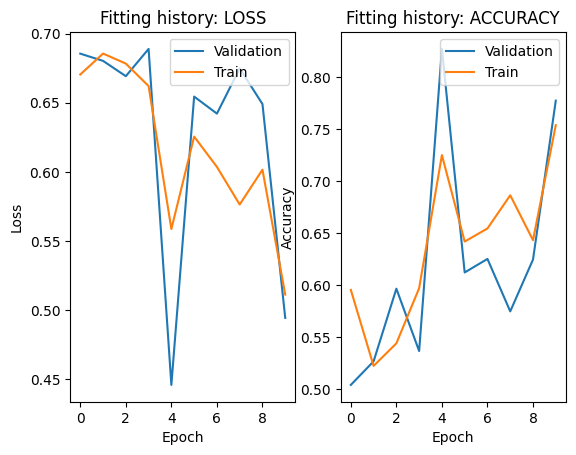

In [55]:
plt.subplot(1,2,1)
plt.plot(history_rnn.history['val_loss']) ## validation loss 
plt.plot(history_rnn.history['loss']) ## training loss (should be decreasing)
plt.title("Fitting history: LOSS")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(history_rnn.history['val_accuracy']) ## validation loss 
plt.plot(history_rnn.history['accuracy']) ## training loss (should be decreasing)
plt.title("Fitting history: ACCURACY")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')


plt.show()

Here it is clear that for training this RNN, the losses and accuracies do not change as steadily over time (epochs) as in the previous cases, but this may also be unfair due to the small sample and short training time (only 10 epochs)

### Predicting on external sources (BBC and The Onion)

In [56]:
print(model_rnn.predict(bbc_pad))
print(model_rnn.predict(theonion_pad))

1/1 [==============================] - 0s 156ms/step
[[0.23600943]]
1/1 [==============================] - 0s 43ms/step
[[0.8541064]]


Poor results on external sources as well.


## Model 2.2: Try training for longer! 

By reusing the same model and fitting it, we are carrying on where we last left off when training the model_rnn model, and hence not starting from scratch. This helps us do additional training.

In [57]:
history_rnn_2 = model_rnn.fit(X_train_pad, y_train, epochs=40, batch_size=200, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/40
289/289 [==============================] - 90s 309ms/step - loss: 0.4118 - accuracy: 0.8492 - val_loss: 0.4118 - val_accuracy: 0.8428
Epoch 2/40
289/289 [==============================] - 89s 308ms/step - loss: 0.5481 - accuracy: 0.7034 - val_loss: 0.4654 - val_accuracy: 0.8031
Epoch 3/40
289/289 [==============================] - 92s 319ms/step - loss: 0.4514 - accuracy: 0.8001 - val_loss: 0.4494 - val_accuracy: 0.7979
Epoch 4/40
289/289 [==============================] - 90s 312ms/step - loss: 0.3896 - accuracy: 0.8472 - val_loss: 0.4273 - val_accuracy: 0.8198
Epoch 5/40
289/289 [==============================] - 90s 311ms/step - loss: 0.3619 - accuracy: 0.8688 - val_loss: 0.4174 - val_accuracy: 0.8340
Epoch 6/40
289/289 [==============================] - 89s 307ms/step - loss: 0.6007 - accuracy: 0.6755 - val_loss: 0.6456 - val_accuracy: 0.6300


In [58]:
print('The model trained for ' ,len(history_rnn_2.history['loss']), ' more epochs before stopping presumably due to early stopping')

The model trained for  6  more epochs before stopping presumably due to early stopping


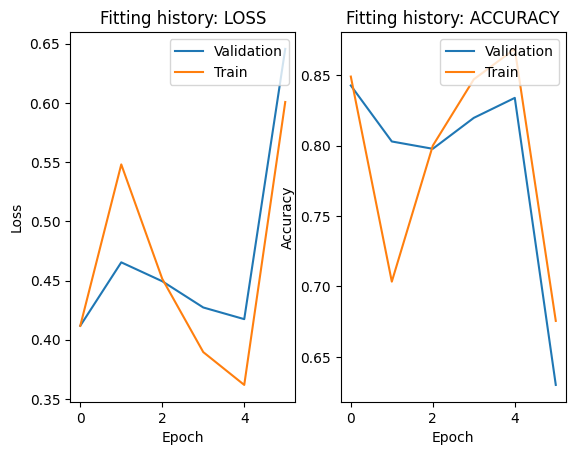

In [59]:
plt.subplot(1,2,1)
plt.plot(history_rnn_2.history['val_loss']) ## validation loss 
plt.plot(history_rnn_2.history['loss']) ## training loss (should be decreasing)
plt.title("Fitting history: LOSS")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(history_rnn_2.history['val_accuracy']) ## validation loss 
plt.plot(history_rnn_2.history['accuracy']) ## training loss (should be decreasing)
plt.title("Fitting history: ACCURACY")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')


plt.show()

There is a bit more stability here - we can at least see that the training loss is decreasing, and both training and validation accuracies are increasing here.

In [60]:
final_train_loss_5 = history_rnn_2.history['loss'][-1]
final_train_accuracy_5 = history_rnn_2.history['accuracy'][-1]

final_val_loss_5 = history_rnn_2.history['val_loss'][-1]
final_val_accuracy_5 = history_rnn_2.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_5)
print("Final Training Accuracy:", final_train_accuracy_5)
print("Final Validation Loss:", final_val_loss_5)
print("Final Validation Accuracy:", final_val_accuracy_5)

Final Training Loss: 0.6007400155067444
Final Training Accuracy: 0.6755229830741882
Final Validation Loss: 0.6455702185630798
Final Validation Accuracy: 0.6300173401832581


In [61]:
models_comparison.loc[len(models_comparison)] =  ['RNN2_more_epochs', final_train_loss_5, final_train_accuracy_5, final_val_loss_5, final_val_accuracy_5]

In [62]:
models_comparison

,Model,Train_loss,Train_acc,Val_loss,Val_acc
0,NN1,0.000110,0.999983,0.174780,0.960555
1,NN2,0.000062,0.999983,0.212608,0.958198
2,NN3,0.097104,0.977903,0.143578,0.966031
3,RNN1,0.511193,0.753843,0.494305,0.777470
4,RNN2_more_epochs,0.600740,0.675523,0.645570,0.630017


Although training numbers have improved, the validation numbers seemed to have worsened. This could potentially be a indication of overfitting 

In [63]:
print(model_rnn.predict(bbc_pad))
print(model_rnn.predict(theonion_pad))

1/1 [==============================] - 0s 40ms/step
[[0.9118658]]
1/1 [==============================] - 0s 46ms/step
[[0.9118658]]


However, the results on the external sources is much better now and close to the neural network model_3 in terms of predictive power on the test observations. 

## Model 3: LSTM layers 

LSTM layers help to solve the vanishing/exploding gradient problem by allowing there to be a long term memory that will not be implicated as much by backpropagation. LSTMs also have gates that control the amount of information and information that go into both the long term memory and the short term memory. Compared to RNNs, this helps with better long term memory. 

In [64]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=8, input_length=avg_length_text),
    LSTM(16),  # 16 LSTM units
    Dropout(0.2),
    Dense(8, activation='relu'),  
    Dropout(0.2),  # Adding dropout
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train_pad, y_train, epochs=50, batch_size=200, 
                              validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/50
289/289 [==============================] - 55s 175ms/step - loss: 0.6715 - accuracy: 0.5512 - val_loss: 0.6234 - val_accuracy: 0.6078
Epoch 2/50
289/289 [==============================] - 25s 87ms/step - loss: 0.5786 - accuracy: 0.6964 - val_loss: 0.4406 - val_accuracy: 0.8534
Epoch 3/50
289/289 [==============================] - 14s 49ms/step - loss: 0.3754 - accuracy: 0.8794 - val_loss: 0.3575 - val_accuracy: 0.8767
Epoch 4/50
289/289 [==============================] - 12s 42ms/step - loss: 0.5854 - accuracy: 0.6773 - val_loss: 0.5892 - val_accuracy: 0.6510
Epoch 5/50
289/289 [==============================] - 8s 29ms/step - loss: 0.5947 - accuracy: 0.6444 - val_loss: 0.5811 - val_accuracy: 0.6579
Epoch 6/50
289/289 [==============================] - 7s 23ms/step - loss: 0.5976 - accuracy: 0.6383 - val_loss: 0.5916 - val_accuracy: 0.6383
Epoch 7/50
289/289 [==============================] - 7s 23ms/step - loss: 0.5594 - accuracy: 0.6793 - val_loss: 0.5268 - val_accuracy: 0

In [65]:
print("Number of epochs to train ", len(history_lstm.history['loss']))

Number of epochs to train  31


In [66]:
final_train_loss_6 = history_lstm.history['loss'][-1]
final_train_accuracy_6 = history_lstm.history['accuracy'][-1]

final_val_loss_6 = history_lstm.history['val_loss'][-1]
final_val_accuracy_6 = history_lstm.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_6)
print("Final Training Accuracy:", final_train_accuracy_6)
print("Final Validation Loss:", final_val_loss_6)
print("Final Validation Accuracy:", final_val_accuracy_6)

Final Training Loss: 0.34518909454345703
Final Training Accuracy: 0.8903967142105103
Final Validation Loss: 0.37006738781929016
Final Validation Accuracy: 0.8709185719490051


In [67]:
print(model_lstm.predict(bbc_pad))
print(model_lstm.predict(theonion_pad))

1/1 [==============================] - 0s 371ms/step
[[0.9784154]]
1/1 [==============================] - 0s 21ms/step
[[0.9784154]]


The predictions for both test instances are oddly close. Let us take a look at the predictions from the validation cases

In [68]:
model_lstm.predict(X_test_pad)

451/451 [==============================] - 2s 5ms/step


array([[0.9784152 ],
       [0.23756655],
       [0.05212672],
       ...,
       [0.8256032 ],
       [0.0521138 ],
       [0.6234363 ]], dtype=float32)